In [1]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
import datetime
import time
import timestring
import math
import scipy
import scipy.sparse

In [2]:
df = pd.read_csv('./Data/2017.csv')

In [3]:
#remove rows will null values which is approximately 1.5%
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

DEP_TIME                 80308
DEP_DELAY                80343
DEP_DELAY_NEW            80343
TAXI_OUT                 82145
WHEELS_OFF               82141
WHEELS_ON                84674
TAXI_IN                  84674
ARR_TIME                 84674
ARR_DELAY                95211
ARR_DELAY_NEW            95211
ACTUAL_ELAPSED_TIME      95211
AIR_TIME                 95211
CARRIER_DELAY          4645148
WEATHER_DELAY          4645148
NAS_DELAY              4645148
SECURITY_DELAY         4645148
LATE_AIRCRAFT_DELAY    4645148
dtype: int64

In [4]:
df = df.dropna(subset=['DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME'])

In [5]:
df = df.fillna(0)

In [6]:
#df = df[['MONTH','DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME',
#       'TAXI_OUT', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY', 'AIR_TIME', 'DISTANCE',
#       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']]

In [7]:
#Let's remove the features that will not be available for predicting flights
df = df[['MONTH','DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME',
       'ARR_TIME', 'ARR_DELAY']]

In [8]:
df = df.reindex()

In [9]:
df.dtypes

MONTH             int64
DAY_OF_MONTH      int64
DAY_OF_WEEK       int64
OP_CARRIER       object
ORIGIN           object
DEST             object
DEP_TIME        float64
ARR_TIME        float64
ARR_DELAY       float64
dtype: object

In [10]:
cat_label = lambda x: x.astype('category')

In [16]:
objects = ['OP_CARRIER', 'ORIGIN', 'DEST']

In [12]:
df[objects] = df[objects].apply(cat_label, axis=0)

In [13]:
df.dtypes

MONTH              int64
DAY_OF_MONTH       int64
DAY_OF_WEEK        int64
OP_CARRIER      category
ORIGIN          category
DEST            category
DEP_TIME         float64
ARR_TIME         float64
ARR_DELAY        float64
dtype: object

In [14]:
dummy_vars = pd.get_dummies(df[objects])

In [15]:
dummy_vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5579410 entries, 0 to 5674620
Columns: 651 entries, OP_CARRIER_AA to DEST_YUM
dtypes: uint8(651)
memory usage: 3.4 GB


In [16]:
df_encoded = pd.concat([df, dummy_vars], axis=1)

In [17]:
df_encoded.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_TIME,ARR_TIME,ARR_DELAY,OP_CARRIER_AA,...,DEST_TYS,DEST_UIN,DEST_UST,DEST_VLD,DEST_VPS,DEST_WRG,DEST_WYS,DEST_XNA,DEST_YAK,DEST_YUM
0,3,21,2,B6,BOS,DCA,1031.0,1154.0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,21,2,B6,IAD,BOS,1420.0,1533.0,-29.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,21,2,B6,BOS,IAD,1203.0,1338.0,-14.0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,21,2,B6,BOS,PHL,758.0,925.0,-11.0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,21,2,B6,FLL,BDL,1041.0,1327.0,-15.0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_encoded = df_encoded.drop(['ORIGIN'], axis=1)

In [19]:
df_encoded = df_encoded.drop(['OP_CARRIER'], axis=1)
df_encoded = df_encoded.drop(['DEST'], axis=1)

In [20]:
df_encoded.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5579410 entries, 0 to 5674620
Columns: 657 entries, MONTH to DEST_YUM
dtypes: float64(3), int64(3), uint8(651)
memory usage: 3.7 GB


In [21]:
df_encoded.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,ARR_DELAY,OP_CARRIER_AA,OP_CARRIER_AS,OP_CARRIER_B6,OP_CARRIER_DL,...,DEST_TYS,DEST_UIN,DEST_UST,DEST_VLD,DEST_VPS,DEST_WRG,DEST_WYS,DEST_XNA,DEST_YAK,DEST_YUM
0,3,21,2,1031.0,1154.0,3.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3,21,2,1420.0,1533.0,-29.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,21,2,1203.0,1338.0,-14.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,21,2,758.0,925.0,-11.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3,21,2,1041.0,1327.0,-15.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#print(f'Size is: {matrix.data.nbytes / 1000000} MB')

Size is: 635.06808 MB


## Linear Regression

In [22]:
y = df_encoded.ARR_DELAY
y_final = y.values
y_final = y_final.reshape(-1,1)

In [23]:
X = df_encoded.drop(['ARR_DELAY'], axis=1)
X = X.values
X_final = scipy.sparse.csr_matrix(X)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.2, random_state=42)

In [26]:
reg_all = LinearRegression()
reg_all.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:
y_pred = reg_all.predict(X_test)

In [28]:
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.03403695777147031
Root Mean Squared Error: 45.13616389259956


This looks like a pretty bad model. Let's see why...

In [43]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 8)

Text(0, 0.5, 'Acutal')

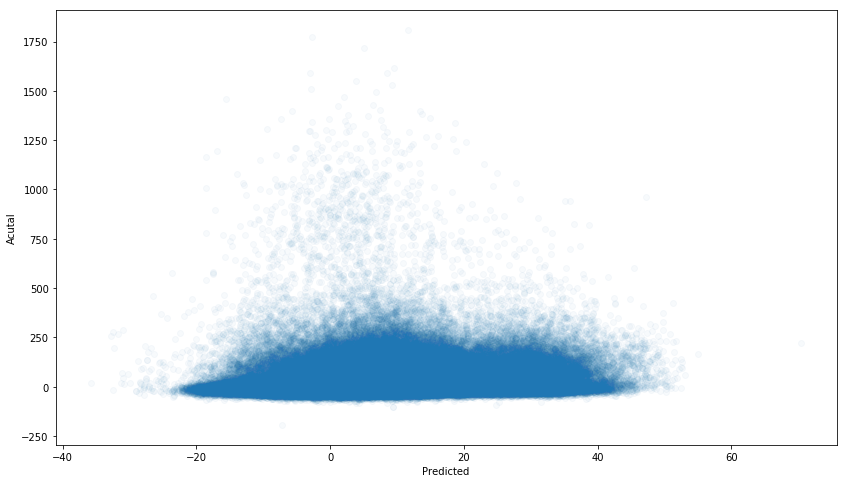

In [45]:
plt.scatter(y_pred, y_test, alpha=0.03)
plt.xlabel('Predicted')
plt.ylabel('Acutal')

In [46]:
predicted = pd.DataFrame(y_pred)

In [47]:
actual = pd.DataFrame(y_test)

In [52]:
df.ARR_DELAY.describe()

count    5.579410e+06
mean     4.326357e+00
std      4.586481e+01
min     -2.380000e+02
25%     -1.500000e+01
50%     -6.000000e+00
75%      7.000000e+00
max      2.189000e+03
Name: ARR_DELAY, dtype: float64

In [50]:
actual.describe()

,0
count,1.115882e+06
mean,4.279662e+00
std,4.592452e+01
min,-1.940000e+02
25%,-1.500000e+01
50%,-6.000000e+00
75%,7.000000e+00
max,1.810000e+03


In [49]:
predicted.describe()

,0
count,1.115882e+06
mean,4.333384e+00
std,8.556587e+00
min,-3.574138e+01
25%,-1.398955e+00
50%,3.565613e+00
75%,8.876435e+00
max,7.046167e+01


In [41]:
y_pred

array([[10.60707428],
       [ 8.08761303],
       [ 8.91422626],
       ...,
       [ 4.67283294],
       [10.2542392 ],
       [11.7139606 ]])

#### Let's try taking out some outliers and re-fitting the data

In [53]:
df_delay = df_encoded[df_encoded.ARR_DELAY < 60]

In [55]:
df_delay.MONTH.count() / df.MONTH.count()

0.9399009931157596

In [56]:
y = df_delay.ARR_DELAY
y_final = y.values
y_final = y_final.reshape(-1,1)

In [57]:
X = df_delay.drop(['ARR_DELAY'], axis=1)
X = X.values
X_final = scipy.sparse.csr_matrix(X)

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.2, random_state=42)

In [60]:
reg_all = LinearRegression()
reg_all.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [61]:
y_pred = reg_all.predict(X_test)

In [62]:
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.05389582083958433
Root Mean Squared Error: 17.099152490451743


Text(0, 0.5, 'Acutal')

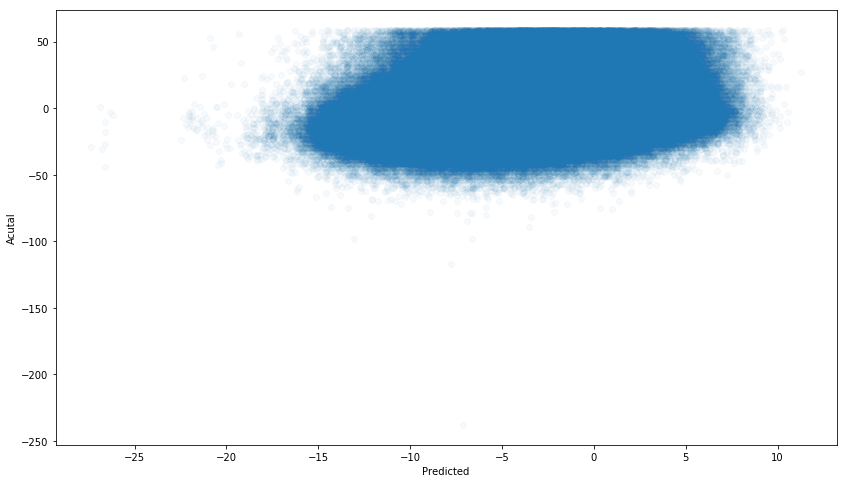

In [63]:
plt.scatter(y_pred, y_test, alpha=0.03)
plt.xlabel('Predicted')
plt.ylabel('Acutal')

Our data has a lot of small airports which do not produce delays...let's take those out and focus on top 50 airports (by traffic volume)

In [67]:
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_TIME,ARR_TIME,ARR_DELAY
0,3,21,2,B6,BOS,DCA,1031.0,1154.0,3.0
1,3,21,2,B6,IAD,BOS,1420.0,1533.0,-29.0
2,3,21,2,B6,BOS,IAD,1203.0,1338.0,-14.0
3,3,21,2,B6,BOS,PHL,758.0,925.0,-11.0
4,3,21,2,B6,FLL,BDL,1041.0,1327.0,-15.0


In [9]:
top50 = df.groupby('ORIGIN').size().sort_values(ascending = False)[0:50]

In [10]:
top50 = list(top50.index)

In [11]:
df_top50 = df[(df.ORIGIN.isin(top50)) & (df.DEST.isin(top50))]

In [12]:
df_top50 = df_top50.reindex()

In [13]:
df_top50.MONTH.count() / df.MONTH.count()

0.6557401230596066

In [14]:
df_top50.ORIGIN.unique()

array(['BOS', 'IAD', 'RSW', 'FLL', 'SJC', 'DCA', 'LAX', 'DEN', 'LGA',
       'AUS', 'JFK', 'TPA', 'EWR', 'SAN', 'SFO', 'ORD', 'MSY', 'HOU',
       'MCO', 'SEA', 'PHX', 'BWI', 'CLE', 'SLC', 'PHL', 'DFW', 'LAS',
       'RDU', 'CLT', 'PDX', 'PIT', 'DTW', 'BNA', 'SMF', 'OAK', 'BUR',
       'ATL', 'IND', 'IAH', 'MCI', 'MKE', 'MSP', 'SNA', 'STL', 'MDW',
       'SAT', 'MIA', 'OGG', 'HNL', 'DAL'], dtype=object)

In [17]:
dummy_vars_50 = pd.get_dummies(df_top50[objects])

In [18]:
df_encoded_50 = pd.concat([df_top50, dummy_vars_50], axis=1)

In [19]:
df_encoded_50.shape

(3658643, 121)

In [20]:
df_encoded_50 = df_encoded_50.drop(['ORIGIN'], axis=1)
df_encoded_50 = df_encoded_50.drop(['OP_CARRIER'], axis=1)
df_encoded_50 = df_encoded_50.drop(['DEST'], axis=1)

In [49]:
from sklearn import preprocessing

In [51]:
y = df_encoded_50.ARR_DELAY
y_final = y.values

min_max_scaler = preprocessing.MinMaxScaler()
y_final = y_final.reshape(-1,1)
y_final_scale = min_max_scaler.fit_transform(y_final)

In [52]:
X = df_encoded_50.drop(['ARR_DELAY'], axis=1)
X = X.values
X_scale = min_max_scaler.fit_transform(X)
X_final = scipy.sparse.csr_matrix(X)
X_final_scale = scipy.sparse.csr_matrix(X_scale)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_final_scale, y_final_scale, test_size = 0.2, random_state=42)

In [54]:
reg_all = LinearRegression()
reg_all.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [55]:
y_pred = reg_all.predict(X_test)

In [56]:
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.0385620334943515
Root Mean Squared Error: 0.018033416778655345


In [57]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 8)

Text(0, 0.5, 'Acutal')

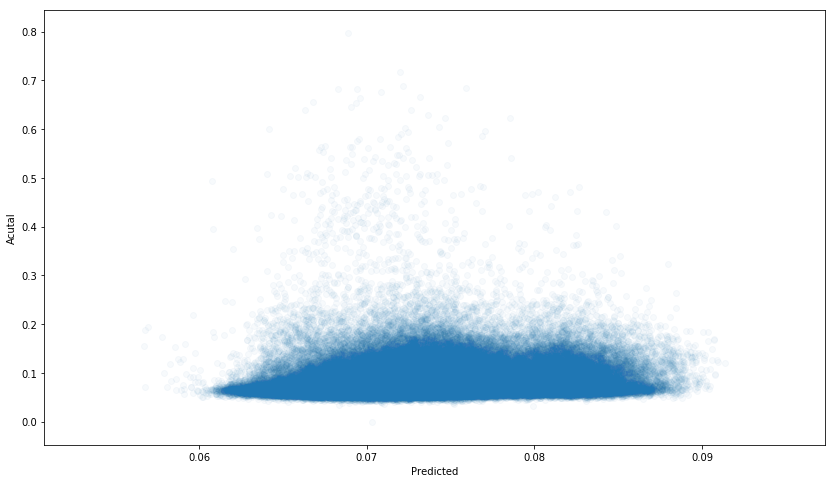

In [58]:
plt.scatter(y_pred, y_test, alpha=0.03)
plt.xlabel('Predicted')
plt.ylabel('Acutal')

   # Using Cross Validation

In [35]:
from sklearn.model_selection import cross_val_score

In [36]:
cv_scores = cross_val_score(reg_all, X_final, y_final, cv=5)
print(cv_scores)

[0.05160902 0.05654497 0.03121805 0.03453374 0.04357212]


# SGD Regressor

In [26]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn

In [23]:
y = df_encoded.ARR_DELAY
y_final = y.values
X = df_encoded.drop(['ARR_DELAY'], axis=1)
X = X.values
X_final = scipy.sparse.csr_matrix(X)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.2, random_state=42)

In [28]:
SGD_par = {'alpha': 10.0**-np.arange(1,7)}

In [29]:
SGD = GridSearchCV(SGDRegressor(random_state = 42), SGD_par, scoring = 'neg_mean_absolute_error', cv = 5)

In [50]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [30]:
SGD.fit(X_train, y_train)

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both ar

/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/dmitriykats/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both ar

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

# SGD Classifier - Will the flight be delayed or not, and probability

# Random Forrest